In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
from torchvision import transforms
# --- SUA O DAY ---
# Chung ta import B0 thay vi V2_B0
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# -----------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import json
import os
import random
from datetime import datetime

# Dat random seeds de dam bao tinh tai lap
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Kiem tra CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: CUDA not available, using CPU")

print("\n✓ Libraries imported successfully")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.4
Available GPU Memory: 14.74 GB

✓ Libraries imported successfully


In [2]:
# Thu muc du lieu tren Kaggle (gia su ban tao dataset ten 'processed-data')
DATA_DIR = '/kaggle/input/coughdatangtval/CoughDataNGT_HaveVAL/'

# Load data
print("Loading data...")
# Doi ten file cua ban cho phu hop (vi du X_train_mel.npy, v.v.)
X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy') # Gia su ban co file validation
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

# Load metadata (class names)
with open(f'{DATA_DIR}/metadata.json', 'r') as f:
    label_info = json.load(f)
    CLASSES = label_info['classes']
    num_classes = len(CLASSES)
    idx_to_label = {int(k): v for k, v in enumerate(CLASSES)}
    label_to_idx = {v: int(k) for k, v in enumerate(CLASSES)}


print(f"✓ Data loaded successfully!")
print(f"\nDataset shapes:")
# Them 1 channel vao du lieu (Batch, Height, Width) -> (Batch, Channel, Height, Width)
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, axis=1)
    X_val = np.expand_dims(X_val, axis=1)
    X_test = np.expand_dims(X_test, axis=1)

model = "CNN_Efficienet"
print(f"Model: {model}")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test:  {X_test.shape}, y_test: {y_test.shape}")
print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {CLASSES}")

Loading data...
✓ Data loaded successfully!

Dataset shapes:
Model: CNN_Efficienet
  X_train: (79966, 1, 128, 216), y_train: (79966,)
  X_val:   (11434, 1, 128, 216), y_val: (11434,)
  X_test:  (22849, 1, 128, 216), y_test: (22849,)

Number of classes: 4
Class names: ['asthma', 'covid', 'healthy', 'tuberculosis']


In [3]:
# Chuyen numpy arrays sang PyTorch tensors
print("Converting data to PyTorch tensors...")
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Tao DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ DataLoaders created successfully!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Converting data to PyTorch tensors...
✓ DataLoaders created successfully!
  Batch size: 32
  Train batches: 2499
  Val batches: 358
  Test batches: 715


In [4]:
# --- MODEL 1: PURE CNN (Giong lop CNN trong CRCNN) ---
class PureCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=4, 
                 conv_channels=[64, 128, 256], dropout=0.5):
        
        super(PureCNN, self).__init__()
        self.conv_blocks = nn.ModuleList()
        self.residual_projs = nn.ModuleList()
        
        in_ch = input_channels
        for i, out_ch in enumerate(conv_channels):
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout * 0.3),
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
            )
            self.conv_blocks.append(block)
            
            if in_ch != out_ch:
                self.residual_projs.append(nn.Conv2d(in_ch, out_ch, 1, bias=False))
            else:
                self.residual_projs.append(None)
            in_ch = out_ch
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_2d = nn.Dropout2d(dropout * 0.4)
        
        # Dau ra cua conv blocks la (batch, 256, 32, 15)
        # Su dung Global Pooling de xu ly kich thuoc
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # Classifier Head moi
        self.classifier_head = nn.Sequential(
            nn.Linear(conv_channels[-1], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: (batch, 1, 256, 126)
        for i, (conv_block, res_proj) in enumerate(zip(self.conv_blocks, self.residual_projs)):
            identity = x
            x = conv_block(x)
            if res_proj is not None:
                identity = res_proj(identity)
            x = x + identity
            x = self.relu(x)
            x = self.pool(x)
            x = self.dropout_2d(x)
        
        # Classifier
        x = self.adaptive_pool(x) # (batch, 256, 1, 1)
        x = self.flatten(x)       # (batch, 256)
        output = self.classifier_head(x) # (batch, num_classes)
        return output

    def get_model_size(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_params': total_params, 'trainable_params': trainable_params}

print("✓ Model 1 (PureCNN) defined.")

✓ Model 1 (PureCNN) defined.


In [5]:
# --- MODEL 2: EfficientNet-B0 (Pure CNN) ---

class EffNetV2B0_CNN(nn.Module): # Ban co the doi ten class neu muon, vi du EffNetB0_CNN
    def __init__(self, num_classes=4, dropout=0.5):
        super(EffNetV2B0_CNN, self).__init__()
        
        self.channel_converter = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU(inplace=True)
        
        # EfficientNetB0 mong doi kich thuoc (224, 224)
        self.resizer = transforms.Resize((224, 224), antialias=True)
        
        # --- SUA O DAY ---
        # Tai mo hinh EfficientNet-B0 pre-trained
        weights = EfficientNet_B0_Weights.DEFAULT
        self.base_model = efficientnet_b0(weights=weights)
        # -----------------
        
        # Thay the lop classifier cuoi cung
        in_features = self.base_model.classifier[1].in_features # Van la 1280
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, 1, 256, 126)
        x = self.relu(self.bn(self.channel_converter(x))) # (batch, 3, 256, 126)
        x = self.resizer(x) # (batch, 3, 224, 224)
        output = self.base_model(x) # (batch, num_classes)
        return output

    def get_model_size(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_params': total_params, 'trainable_params': trainable_params}

print("✓ Model 2 (EfficientNetB0_CNN) defined.")

✓ Model 2 (EfficientNetB0_CNN) defined.


In [6]:
# --- MODEL 3: EfficientNet-B0 (Backbone) + RNN/Attention ---

class EffNetV2B0_CRNN(nn.Module): # Ban co the doi ten class neu muon
    def __init__(self, num_classes=4, rnn_hidden_size=256, rnn_layers=2, dropout=0.5, attention_heads=4):
        super(EffNetV2B0_CRNN, self).__init__()
        
        # --- CNN Backbone (EfficientNetB0) ---
        self.channel_converter = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU(inplace=True)
        self.resizer = transforms.Resize((224, 224), antialias=True)
        
        # --- SUA O DAY ---
        weights = EfficientNet_B0_Weights.DEFAULT
        self.base_model = efficientnet_b0(weights=weights)
        # -----------------
        
        self.cnn_features = self.base_model.features
        
        # --- LOP ADAPTIVE ---
        # Dau ra cua EffNetB0 features sau khi resize la (batch, 1280, 7, 7)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 32)) 
        
        # --- LOP RNN (Giong nhu CRCNN goc) ---
        self.feature_channels = 1280 # Dau ra cua EffNetB0 van la 1280
        self.rnn_hidden_size = rnn_hidden_size
        
        self.pre_rnn_proj = nn.Sequential(
            nn.Linear(self.feature_channels, rnn_hidden_size),
            nn.LayerNorm(rnn_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5)
        )
        
        self.gru = nn.GRU(
            input_size=rnn_hidden_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=dropout * 0.5 if rnn_layers > 1 else 0,
            bidirectional=True
        )
        
        # --- LOP ATTENTION & CLASSIFIER (Giong het notebook goc) ---
        self.attention_heads = attention_heads
        gru_output_size = rnn_hidden_size * 2
        
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(gru_output_size, 64),
                nn.Tanh(),
                nn.Dropout(dropout * 0.3),
                nn.Linear(64, 1)
            ) for _ in range(attention_heads)
        ])
        
        classifier_input_size = gru_output_size * attention_heads
        
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.6),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)
            
    def forward(self, x):
        # CNN Backbone
        x = self.relu(self.bn(self.channel_converter(x))) 
        x = self.resizer(x) 
        x = self.cnn_features(x) # (batch, 1280, 7, 7)
        
        # Adaptive & Reshape
        x = self.adaptive_pool(x) # (batch, 1280, 1, 32)
        x = x.squeeze(2).permute(0, 2, 1) # (batch, 32, 1280)
        
        # RNN
        x = self.pre_rnn_proj(x) 
        gru_out, _ = self.gru(x) 
        
        # Attention & Classifier
        attended_features = []
        for attention_layer in self.attention_layers:
            attention_scores = attention_layer(gru_out)
            attention_weights = torch.softmax(attention_scores, dim=1)
            attended = torch.sum(gru_out * attention_weights, dim=1)
            attended_features.append(attended)
        
        context = torch.cat(attended_features, dim=1)
        output = self.classifier(context)
        return output

    def get_model_size(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_params': total_params, 'trainable_params': trainable_params}

print("✓ Model 3 (EfficientNetB0_CRNN) defined.")

✓ Model 3 (EfficientNetB0_CRNN) defined.


In [7]:
# ===========================================
# KHOI TAO MODEL (CHON 1 TRONG 3)
# ===========================================
print("="*80)
print("🚀 INITIALIZING MODEL")
print("="*80)

if(model == "CNN"):
    # --- LUA CHON 1: PureCNN ---
    model = PureCNN(
        input_channels=X_train_tensor.shape[1],
        num_classes=num_classes,
        dropout=0.5
    ).to(device)
    print("Da chon Model 1: PureCNN")

if(model == "CNN_Efficienet"):
    # --- LUA CHON 2: EfficientNetV2-B0 CNN ---
    model = EffNetV2B0_CNN(
        num_classes=num_classes,
        dropout=0.5
    ).to(device)
    print("Da chon Model 2: EfficientNetV2-B0 CNN")
if(model == "CRNN"):
    #--- LUA CHON 3: EfficientNetV2-B0 CRNN ---
    model = EffNetV2B0_CRNN(
        num_classes=num_classes,
        rnn_hidden_size=256,
        rnn_layers=2,
        dropout=0.5,
        attention_heads=4
    ).to(device)
    print("Da chon Model 3: EfficientNetV2-B0 CRNN")


# Thong tin model
model_info = model.get_model_size()
print(f"\n📊 Model Information:")
print(f"  Total parameters: {model_info['total_params']:,}")
print(f"  Trainable parameters: {model_info['trainable_params']:,}")

# Kiem tra forward pass
print(f"\n🧪 Testing model forward pass...")
model.eval()
with torch.no_grad():
    sample_input = X_train_tensor[:2].to(device)
    sample_output = model(sample_input)
    
print(f"  Input shape: {sample_input.shape}")
print(f"  Output shape: {sample_output.shape}")
print(f"✅ Model initialized successfully!")
print("="*80)

🚀 INITIALIZING MODEL


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s] 


Da chon Model 2: EfficientNetV2-B0 CNN

📊 Model Information:
  Total parameters: 4,012,681
  Trainable parameters: 4,012,681

🧪 Testing model forward pass...
  Input shape: torch.Size([2, 1, 128, 216])
  Output shape: torch.Size([2, 4])
✅ Model initialized successfully!


In [8]:
# ===========================================
# CAU HINH HUAN LUYEN (Giong het notebook crcnn.ipynb)
# ===========================================

from sklearn.utils.class_weight import compute_class_weight

# Tinh trong so lop
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("📊 Class Distribution:")
for i, (label, weight) in enumerate(zip(idx_to_label.values(), class_weights)):
    count = np.sum(y_train == i)
    print(f"  Class {i} ({label}): {count} samples, weight={weight:.3f}")

# Loss function voi class weights va label smoothing
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor, 
    label_smoothing=0.1  # Giam overfitting
)

# Optimizer: AdamW voi weight decay
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001,              
    weight_decay=0.01,     # Chinh quy hoa L2
    betas=(0.9, 0.999),
)

# Hoc Giam LR khi het kien nhan
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # Toi da hoa val accuracy
    factor=0.5,           # Giam LR 50%
    patience=5,           # Cho 5 epochs
    min_lr=1e-6,
)

print("\n⚙️  TRAINING CONFIGURATION:")
print(f"  Loss: CrossEntropyLoss (class-weighted, label_smoothing=0.1)")
print(f"  Optimizer: AdamW (lr=0.001, weight_decay=0.01)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  Gradient clipping: 1.0")

📊 Class Distribution:
  Class 0 (asthma): 2513 samples, weight=7.955
  Class 1 (covid): 30499 samples, weight=0.655
  Class 2 (healthy): 40916 samples, weight=0.489
  Class 3 (tuberculosis): 6038 samples, weight=3.311

⚙️  TRAINING CONFIGURATION:
  Loss: CrossEntropyLoss (class-weighted, label_smoothing=0.1)
  Optimizer: AdamW (lr=0.001, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  Gradient clipping: 1.0


In [9]:
# ===========================================
# DATA AUGMENTATION (SpecAugment)
# ===========================================

def spec_augment_tensor(spectrogram, num_time_masks=2, time_mask_max_pct=0.1,
                        num_freq_masks=2, freq_mask_max_pct=0.15):
    """Ap dung SpecAugment len mot tensor (C, H, W)"""
    aug = spectrogram.clone()
    if aug.dim() == 3:
        _, freq_size, time_size = aug.shape
    elif aug.dim() == 2:
        freq_size, time_size = aug.shape
    else:
        return aug

    # Frequency masking
    for _ in range(num_freq_masks):
        f = int(random.uniform(0.0, freq_mask_max_pct) * freq_size)
        if f == 0: continue
        f0 = random.randint(0, max(0, freq_size - f))
        if aug.dim() == 3:
            aug[:, f0:f0+f, :] = 0
        else:
            aug[f0:f0+f, :] = 0

    # Time masking
    for _ in range(num_time_masks):
        t = int(random.uniform(0.0, time_mask_max_pct) * time_size)
        if t == 0: continue
        t0 = random.randint(0, max(0, time_size - t))
        if aug.dim() == 3:
            aug[:, :, t0:t0+t] = 0
        else:
            aug[:, t0:t0+t] = 0
    return aug

def augmentation_batch(batch_inputs, prob=0.8):
    """Ap dung augmentation cho 1 batch voi xac suat"""
    if random.random() > prob:
        return batch_inputs
    aug_batch = batch_inputs.clone()
    for i in range(aug_batch.size(0)):
        aug_batch[i] = spec_augment_tensor(aug_batch[i])
    return aug_batch

# Gan ham augmentation
augmentation = augmentation_batch

print("✓ SpecAugment augmentation ready (applied with probability ~0.8)")

✓ SpecAugment augmentation ready (applied with probability ~0.8)


In [10]:
# ===========================================
# HAM HUAN LUYEN & KIEM DINH
# ===========================================

def train_epoch(model, train_loader, criterion, optimizer, device, augmentation=None):
    """Train 1 epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, targets in train_bar:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        if augmentation is not None:
            inputs = augmentation(inputs)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient Clipping
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_bar.set_postfix({
            'Loss': f'{running_loss/(train_bar.n+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """Validate 1 epoch"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, targets in val_bar:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            val_bar.set_postfix({
                'Loss': f'{val_loss/(val_bar.n+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = val_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    # Tra ve them all_preds, all_targets de su dung cho ham train_model
    return epoch_loss, epoch_acc, all_preds, all_targets

print("✓ Training and validation functions defined successfully!")

✓ Training and validation functions defined successfully!


In [11]:
# ===========================================
# VONG LAP HUAN LUYEN CHINH (Voi Early Stopping)
# ===========================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=80, early_stopping_patience=10, 
                save_path='best_model.pth'):
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print("\n" + "="*80)
    print("🎓 STARTING TRAINING")
    print(f"Model will be saved to: {save_path}")
    print("="*80 + "\n")
    
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print("-" * 40)
        
        # Training
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, 
            augmentation=augmentation
        )
        
        # Validation
        val_loss, val_acc, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Scheduler
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Luu history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        epoch_time = (datetime.now() - epoch_start_time).total_seconds()
        
        print(f"\n📊 Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.2e}")
        print(f"  Epoch Time: {epoch_time:.1f}s")
        
        # Luu model tot nhat
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history,
                'class_names': CLASSES
            }
            torch.save(checkpoint, save_path)
            
            print(f"  ✅ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{early_stopping_patience})")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n{'='*80}")
            print(f"⏹️  Early stopping triggered!")
            print(f"   Best validation accuracy: {best_val_acc:.2f}%")
            print("="*80)
            break
        
        print("")
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETED!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Model saved to: {save_path}")
    print("="*80 + "\n")
    
    return history, best_val_acc

print("✅ Training loop function defined!")

✅ Training loop function defined!


In [12]:
# ===========================================
# BAT DAU HUAN LUYEN
# ===========================================

NUM_EPOCHS = 80
EARLY_STOPPING_PATIENCE = 10
MODEL_SAVE_PATH = '/kaggle/working/best_model.pth'

# Bat dau
history, best_val_acc = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_path=MODEL_SAVE_PATH
)

print(f"\n🎉 Training finished!")
print(f"📈 Best validation accuracy achieved: {best_val_acc:.2f}%")


🎓 STARTING TRAINING
Model will be saved to: /kaggle/working/best_model.pth

Epoch [1/80]
----------------------------------------



📊 Results:
  Train Loss: 1.3474 | Train Acc: 34.34%
  Val Loss:   1.3122 | Val Acc:   24.46%
  Learning Rate: 1.00e-03
  Epoch Time: 412.9s
  ✅ New best model saved! (Val Acc: 24.46%)

Epoch [2/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2954 | Train Acc: 36.08%
  Val Loss:   1.2895 | Val Acc:   51.50%
  Learning Rate: 1.00e-03
  Epoch Time: 413.2s
  ✅ New best model saved! (Val Acc: 51.50%)

Epoch [3/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2837 | Train Acc: 38.30%
  Val Loss:   1.3015 | Val Acc:   19.46%
  Learning Rate: 1.00e-03
  Epoch Time: 413.7s
  No improvement (1/10)

Epoch [4/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2711 | Train Acc: 40.31%
  Val Loss:   1.2800 | Val Acc:   44.77%
  Learning Rate: 1.00e-03
  Epoch Time: 413.4s
  No improvement (2/10)

Epoch [5/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2704 | Train Acc: 41.86%
  Val Loss:   1.2793 | Val Acc:   48.11%
  Learning Rate: 1.00e-03
  Epoch Time: 413.3s
  No improvement (3/10)

Epoch [6/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2612 | Train Acc: 43.63%
  Val Loss:   1.2909 | Val Acc:   38.71%
  Learning Rate: 1.00e-03
  Epoch Time: 413.1s
  No improvement (4/10)

Epoch [7/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2522 | Train Acc: 44.30%
  Val Loss:   1.2788 | Val Acc:   42.49%
  Learning Rate: 1.00e-03
  Epoch Time: 413.4s
  No improvement (5/10)

Epoch [8/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2475 | Train Acc: 45.53%
  Val Loss:   1.2827 | Val Acc:   50.13%
  Learning Rate: 5.00e-04
  Epoch Time: 413.2s
  No improvement (6/10)

Epoch [9/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2257 | Train Acc: 50.32%
  Val Loss:   1.2790 | Val Acc:   45.47%
  Learning Rate: 5.00e-04
  Epoch Time: 413.5s
  No improvement (7/10)

Epoch [10/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2117 | Train Acc: 52.98%
  Val Loss:   1.2791 | Val Acc:   52.70%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  ✅ New best model saved! (Val Acc: 52.70%)

Epoch [11/80]
----------------------------------------



📊 Results:
  Train Loss: 1.2016 | Train Acc: 56.36%
  Val Loss:   1.2885 | Val Acc:   60.43%
  Learning Rate: 5.00e-04
  Epoch Time: 414.0s
  ✅ New best model saved! (Val Acc: 60.43%)

Epoch [12/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1839 | Train Acc: 60.35%
  Val Loss:   1.2887 | Val Acc:   54.28%
  Learning Rate: 5.00e-04
  Epoch Time: 414.2s
  No improvement (1/10)

Epoch [13/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1734 | Train Acc: 62.95%
  Val Loss:   1.3145 | Val Acc:   55.94%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  No improvement (2/10)

Epoch [14/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1574 | Train Acc: 65.03%
  Val Loss:   1.2986 | Val Acc:   59.71%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  No improvement (3/10)

Epoch [15/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1466 | Train Acc: 66.90%
  Val Loss:   1.3091 | Val Acc:   67.18%
  Learning Rate: 5.00e-04
  Epoch Time: 413.9s
  ✅ New best model saved! (Val Acc: 67.18%)

Epoch [16/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1389 | Train Acc: 69.38%
  Val Loss:   1.3124 | Val Acc:   62.45%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  No improvement (1/10)

Epoch [17/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1250 | Train Acc: 70.65%
  Val Loss:   1.3385 | Val Acc:   62.98%
  Learning Rate: 5.00e-04
  Epoch Time: 414.3s
  No improvement (2/10)

Epoch [18/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1148 | Train Acc: 72.02%
  Val Loss:   1.3072 | Val Acc:   66.21%
  Learning Rate: 5.00e-04
  Epoch Time: 413.7s
  No improvement (3/10)

Epoch [19/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1117 | Train Acc: 73.29%
  Val Loss:   1.3121 | Val Acc:   69.44%
  Learning Rate: 5.00e-04
  Epoch Time: 413.6s
  ✅ New best model saved! (Val Acc: 69.44%)

Epoch [20/80]
----------------------------------------



📊 Results:
  Train Loss: 1.1040 | Train Acc: 74.33%
  Val Loss:   1.3239 | Val Acc:   67.10%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  No improvement (1/10)

Epoch [21/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0957 | Train Acc: 75.01%
  Val Loss:   1.3241 | Val Acc:   68.58%
  Learning Rate: 5.00e-04
  Epoch Time: 414.1s
  No improvement (2/10)

Epoch [22/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0912 | Train Acc: 75.66%
  Val Loss:   1.3316 | Val Acc:   69.39%
  Learning Rate: 5.00e-04
  Epoch Time: 413.7s
  No improvement (3/10)

Epoch [23/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0877 | Train Acc: 76.16%
  Val Loss:   1.3462 | Val Acc:   67.16%
  Learning Rate: 5.00e-04
  Epoch Time: 414.0s
  No improvement (4/10)

Epoch [24/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0848 | Train Acc: 76.59%
  Val Loss:   1.3435 | Val Acc:   68.77%
  Learning Rate: 5.00e-04
  Epoch Time: 414.4s
  No improvement (5/10)

Epoch [25/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0738 | Train Acc: 77.37%
  Val Loss:   1.3339 | Val Acc:   71.04%
  Learning Rate: 5.00e-04
  Epoch Time: 413.9s
  ✅ New best model saved! (Val Acc: 71.04%)

Epoch [26/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0710 | Train Acc: 78.09%
  Val Loss:   1.3521 | Val Acc:   70.95%
  Learning Rate: 5.00e-04
  Epoch Time: 413.9s
  No improvement (1/10)

Epoch [27/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0648 | Train Acc: 78.69%
  Val Loss:   1.3406 | Val Acc:   67.81%
  Learning Rate: 5.00e-04
  Epoch Time: 413.8s
  No improvement (2/10)

Epoch [28/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0624 | Train Acc: 79.12%
  Val Loss:   1.3472 | Val Acc:   66.98%
  Learning Rate: 5.00e-04
  Epoch Time: 414.1s
  No improvement (3/10)

Epoch [29/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0614 | Train Acc: 79.32%
  Val Loss:   1.3485 | Val Acc:   69.75%
  Learning Rate: 5.00e-04
  Epoch Time: 413.9s
  No improvement (4/10)

Epoch [30/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0554 | Train Acc: 80.03%
  Val Loss:   1.3440 | Val Acc:   70.26%
  Learning Rate: 5.00e-04
  Epoch Time: 413.6s
  No improvement (5/10)

Epoch [31/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0510 | Train Acc: 80.10%
  Val Loss:   1.3529 | Val Acc:   68.74%
  Learning Rate: 2.50e-04
  Epoch Time: 414.2s
  No improvement (6/10)

Epoch [32/80]
----------------------------------------



📊 Results:
  Train Loss: 1.0113 | Train Acc: 84.14%
  Val Loss:   1.3668 | Val Acc:   70.05%
  Learning Rate: 2.50e-04
  Epoch Time: 413.7s
  No improvement (7/10)

Epoch [33/80]
----------------------------------------



📊 Results:
  Train Loss: 0.9977 | Train Acc: 85.29%
  Val Loss:   1.3708 | Val Acc:   69.84%
  Learning Rate: 2.50e-04
  Epoch Time: 413.7s
  No improvement (8/10)

Epoch [34/80]
----------------------------------------



📊 Results:
  Train Loss: 0.9904 | Train Acc: 86.09%
  Val Loss:   1.3913 | Val Acc:   70.22%
  Learning Rate: 2.50e-04
  Epoch Time: 413.5s
  No improvement (9/10)

Epoch [35/80]
----------------------------------------



📊 Results:
  Train Loss: 0.9821 | Train Acc: 86.92%
  Val Loss:   1.3913 | Val Acc:   69.23%
  Learning Rate: 2.50e-04
  Epoch Time: 413.7s
  No improvement (10/10)

⏹️  Early stopping triggered!
   Best validation accuracy: 71.04%

✅ TRAINING COMPLETED!
Best Validation Accuracy: 71.04%
Model saved to: /kaggle/working/best_model.pth


🎉 Training finished!
📈 Best validation accuracy achieved: 71.04%


In [13]:
# ===========================================
# DANH GIA TREN TAP TEST
# ===========================================

def evaluate_model(model, test_loader, device, model_path=None):
    """Danh gia model tren tap test"""
    
    if model_path and os.path.exists(model_path):
        print(f"Loading best model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Model loaded (Best val acc: {checkpoint.get('best_val_acc', 0.0):.2f}%)\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Danh gia
y_pred, y_true = evaluate_model(model, test_loader, device, model_path=MODEL_SAVE_PATH)

# Tinh metrics
test_accuracy = accuracy_score(y_true, y_pred)

print("\n" + "=" * 60)
print("🎯 TEST SET RESULTS")
print("=" * 60)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))
print("=" * 60)

Loading best model from /kaggle/working/best_model.pth...
✅ Model loaded (Best val acc: 71.04%)

Evaluating on test set...


Testing: 100%|██████████| 715/715 [00:27<00:00, 26.27it/s]



🎯 TEST SET RESULTS
Test Accuracy: 70.93%

Classification Report:
              precision    recall  f1-score   support

      asthma       0.05      0.07      0.06       717
       covid       0.67      0.69      0.68      8711
     healthy       0.76      0.72      0.74     11690
tuberculosis       0.98      0.99      0.99      1731

    accuracy                           0.71     22849
   macro avg       0.61      0.62      0.62     22849
weighted avg       0.72      0.71      0.71     22849



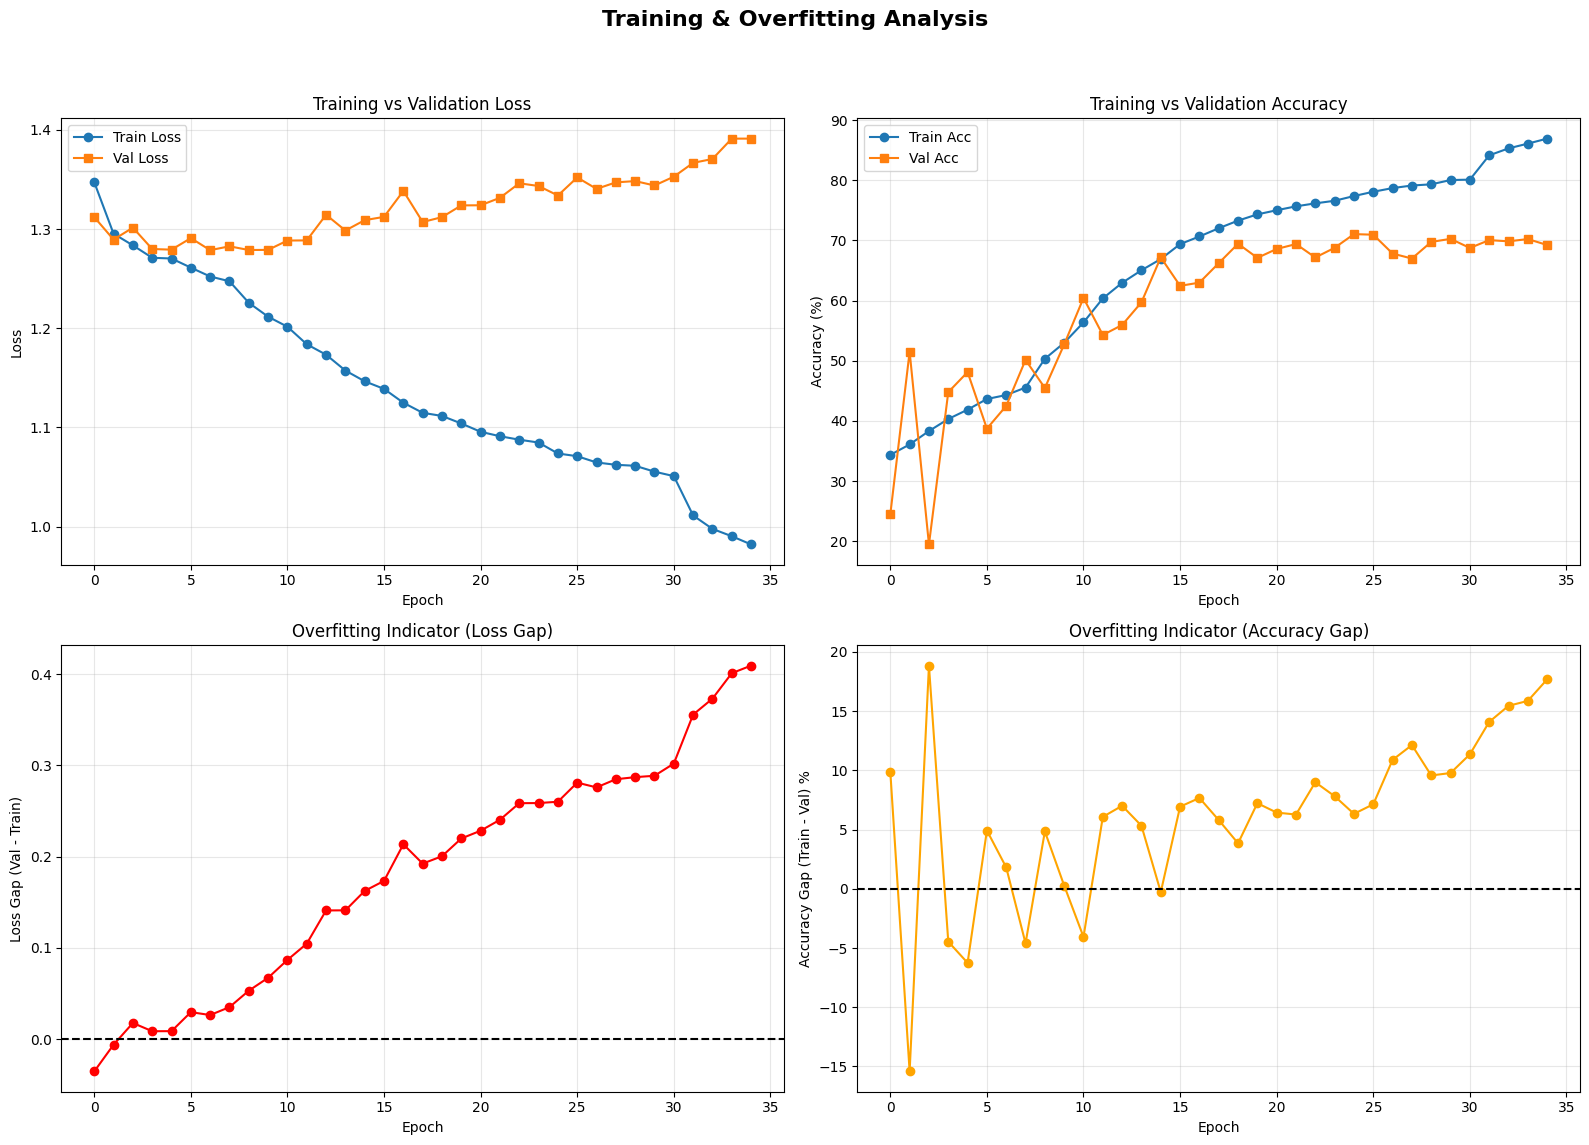

✓ Bieu do lich su huan luyen da duoc luu.


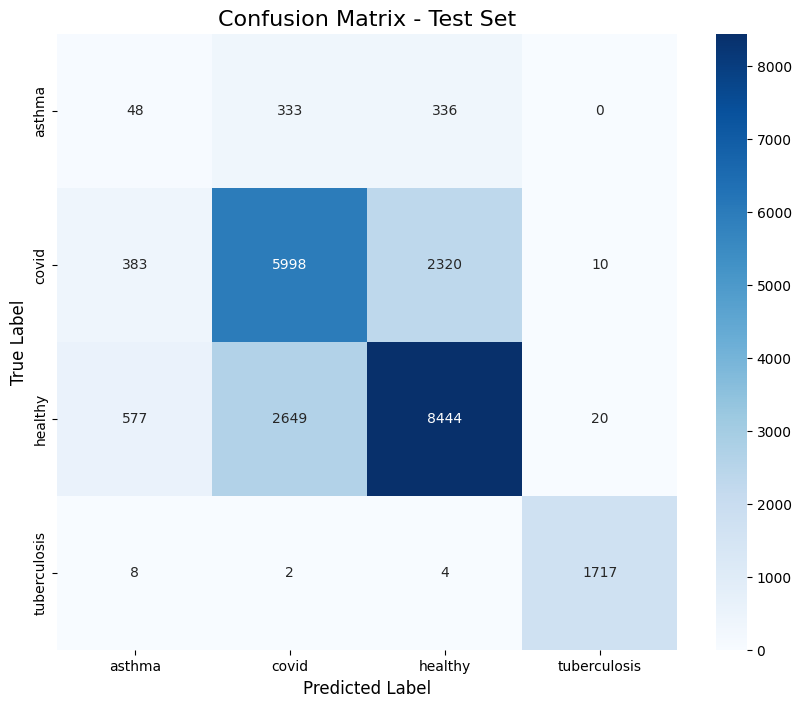

✓ Ma tran nham lan da duoc luu.


In [14]:
# ===========================================
# VE BIEU DO KET QUA
# ===========================================

def plot_training_history(history, save_path):
    """Ve bieu do loss va accuracy"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training & Overfitting Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_title('Training vs Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Loss Gap (Overfitting)
    loss_gap = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 0].plot(loss_gap, marker='o', color='red')
    axes[1, 0].axhline(y=0, color='black', linestyle='--')
    axes[1, 0].set_title('Overfitting Indicator (Loss Gap)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Gap (Val - Train)')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Accuracy Gap (Overfitting)
    acc_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 1].plot(acc_gap, marker='o', color='orange')
    axes[1, 1].axhline(y=0, color='black', linestyle='--')
    axes[1, 1].set_title('Overfitting Indicator (Accuracy Gap)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Gap (Train - Val) %')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=300)
    plt.show()

# Ve bieu do
plot_training_history(history, '/kaggle/working/training_history.png')
print("✓ Bieu do lich su huan luyen da duoc luu.")

# Ve ma tran nham lan
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300)
plt.show()
print("✓ Ma tran nham lan da duoc luu.")